# Sequential Minimal Optimization

This notebook implements SMO as introduced in "Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines" by John C. Platt.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from pyrsistent import b

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [82]:
%matplotlib widget

def linear_kernel(x1, x2):
    return x1.T @ x2

def polynomial_kernel(x1,x2):
    return (x1 @ x2.T)**2

class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel == 'poly':
            self._k = polynomial_kernel
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b
        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # Computation for negative case
        else:
            f1 = y1 * (e1 + self._b) - (alpha1 * k11 ) - (s * alpha2 * k12)
            f2 = y2 * (e2 + self._b) - (s * alpha1 * k12) - ( alpha2 * k22)
            L1 = alpha1 + (s * (alpha2 - L))
            H1 = alpha1 + (s * (alpha2 - H))
            Lobj = (L1 * f1) + (L * f2) + (0.5 * L1**2 * k11) + (0.5 * L**2 * k22) + (s * L * L1 * k12)
            Hobj = (H1 * f1) + (H * f2) + (0.5 * H1**2 * k11) + (0.5 * H**2 * k22) + (s * H * H1 * k12)
            if Lobj < (Hobj - 1e-3):
                a2 = L
            elif Lobj < (Hobj + 1e-3):
                a2 = H
            else:
                a2 = alpha2
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

<h3>Genearate Linear Data Samples</h3>

In [83]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


<h3>Linear Data Classification With Developed Model</h3>

In [84]:
dev_lin_model = svm(c=5.0)
dev_lin_model.fit(samples, targets)
print(dev_lin_model._weights)
print(dev_lin_model._b)

[ 0.87608502 -0.77139871]
-0.3233204894857178


weights=[ 0.87608502 -0.77139871]
b=-0.3233204894857178


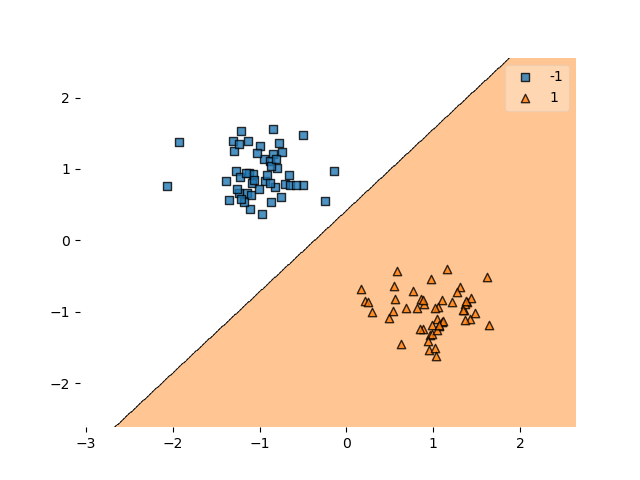

In [85]:
# for i in range(samples.shape[0]):
#     print(f"Sample {i}: score={model.predict_score(samples[i])}, alpha={model._alphas[i]}")


print(f"weights={dev_lin_model._weights}")
print(f"b={dev_lin_model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), dev_lin_model)
fig.add_subplot(ax)
plt.show()

<h3>Linear Data Classification With SVM Linear Kernel</h3>

coef_=[[ 0.62199779 -0.96068773]]
intercept=[0.03108611]


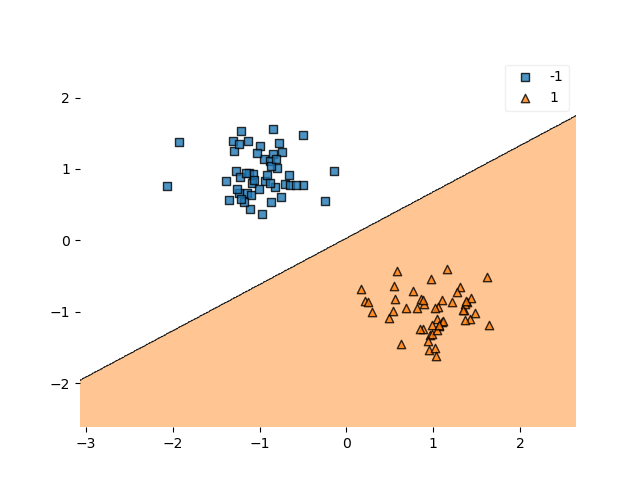

In [86]:
from sklearn.svm import LinearSVC


sk_model = LinearSVC()
sk_model.fit(samples, targets.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

<h3>Non Linear Data Generation </h3>

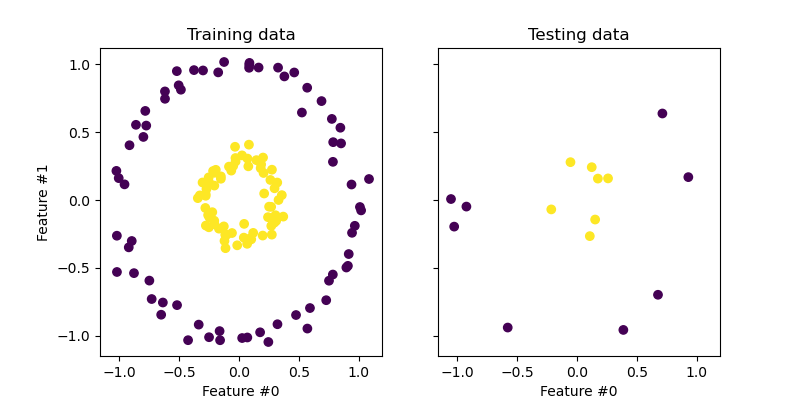

In [87]:
# Non linear dataset

X, y = make_circles(n_samples=150, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1 ,stratify=y, random_state=0)

#visualising non linear dataset

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [88]:
#shapes 
print(f'original X shape - {X.shape}')
print(f'original y shape - {y.shape}')
print(f'train X split shape - {X_train.shape}')
print(f'train y split shape - {y_train.shape}')
print(f'test x split shape- {X_test.shape}')
print(f'test y split shape - {y_test.shape}')

original X shape - (150, 2)
original y shape - (150,)
train X split shape - (135, 2)
train y split shape - (135,)
test x split shape- (15, 2)
test y split shape - (15,)


<h3>Non Linear Data Classification With Developed Model(Linear Kernel)</h3>

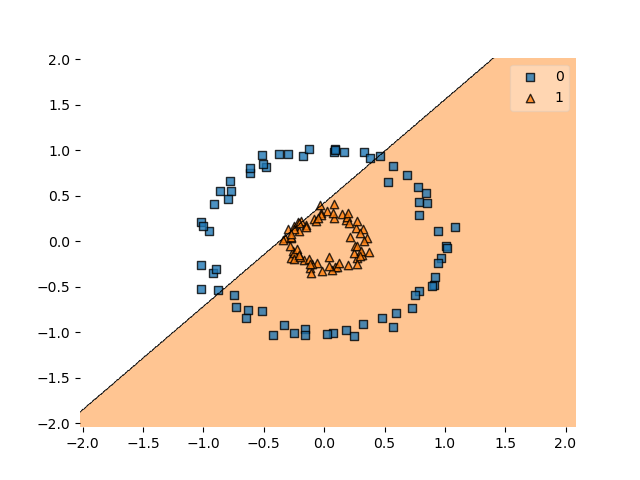

In [89]:
fig_2 = plt.figure()
ax_2= plot_decision_regions(X_train, y_train.astype(np.int32), dev_lin_model)
fig_2.add_subplot(ax_2)
plt.show()

<h3>Non Linear Data Classification with Sklearn SVM(Linear Kernel)</h3>

coef_=[[-0.0198542  -0.00811586]]
intercept=[0.00754583]


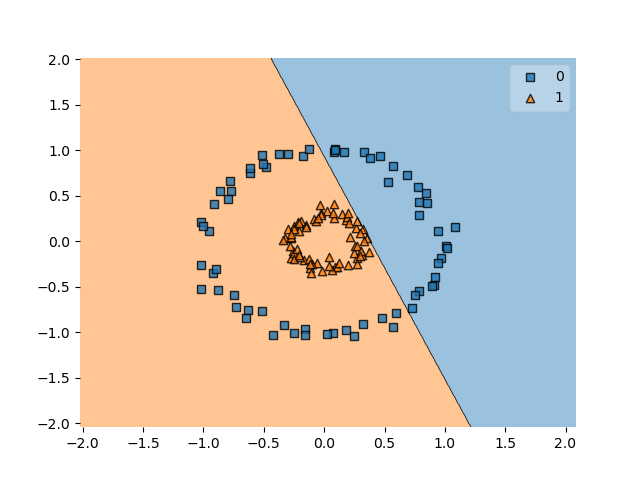

In [90]:
from sklearn.svm import LinearSVC

#Linear case check 
sk_model4 = LinearSVC()
sk_model4.fit(X_train, y_train.astype(np.int32))

print(f"coef_={sk_model4.coef_}")
print(f"intercept={sk_model4.intercept_}")

fig4 = plt.figure()
ax4 = plot_decision_regions(X_train, y_train.astype(np.int32), sk_model4)
fig4.add_subplot(ax4)
plt.show()

<h3>Non Linear Data Classification With Developed Model(Poly Kernel)</h3>

In [91]:
dev_poly_model = svm(c=5.0,kernel='poly')
dev_poly_model.fit(X_train, y_train)
print(dev_poly_model._b)

10.678474950714367


In [92]:
def get_accuracy(y_prediction,y_actual ):
    return np.sum(y_prediction == y_actual)/len(y_actual)

In [93]:
y_pred = dev_poly_model.predict(X_test)
y_pred = np.where(y_pred == 1 , 0, y_pred.astype(np.int32))
y_pred = np.where(y_pred == -1 , 1, y_pred.astype(np.int32))
print(f' y_prediction- {y_pred}')
print(f' y_actual - {y_test}' )
accuracy = get_accuracy(y_pred, y_test)
print(f'Accuracy of the developed model- {round(accuracy*100,2)}%')


 y_prediction- [0 0 1 0 1 0 0 1 0 1 0 1 1 1 0]
 y_actual - [0 0 1 0 1 0 0 1 0 1 0 1 1 1 0]
Accuracy of the developed model- 100.0%


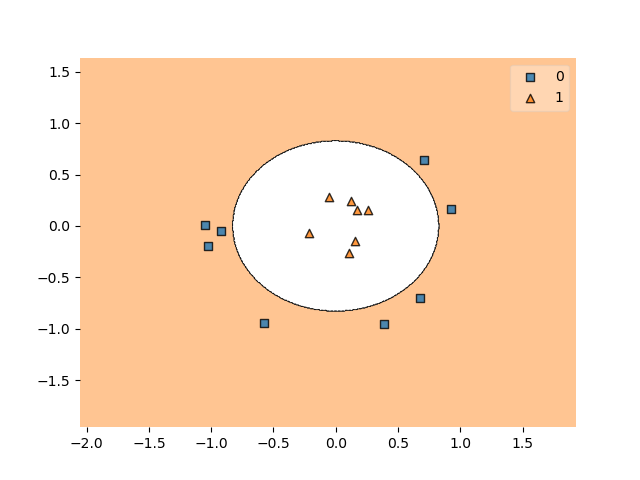

In [94]:
fig_2 = plt.figure()
ax_2= plot_decision_regions(X_test, y_test.astype(np.int32), dev_poly_model)
fig_2.add_subplot(ax_2)
plt.show()

<h3>Non Linear Data Classification with Sklearn SVM(Ploy Kernel)</h3>

intercept=[0.9345818]


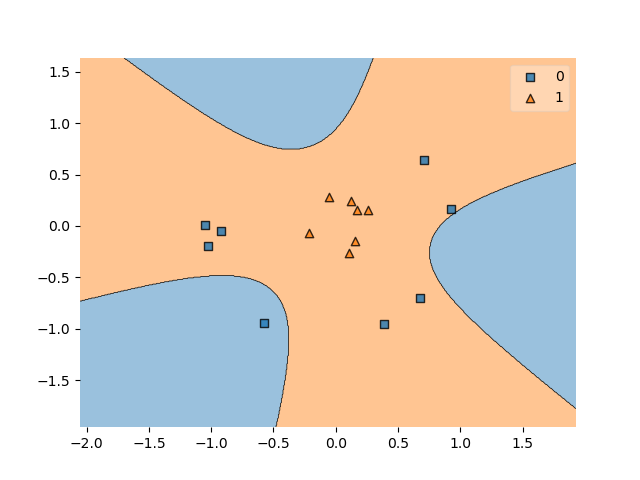

In [95]:
from sklearn.svm import SVC
# Non linear case check 

sk_model2 = SVC(kernel='poly')
sk_model2.fit(X_train, y_train.astype(np.int32))

#print(f"coef_={sk_model2.coef_}")
print(f"intercept={sk_model2.intercept_}")

fig2 = plt.figure()
ax2 = plot_decision_regions(X_test, y_test.astype(np.int32), sk_model2)
fig2.add_subplot(ax2)
plt.show()

<h1>3. Multi-class SVM</h1>

In [96]:
class MultiSVM:
    
    def __init__(self, k=3):
        for i in range(1,k+1):
            setattr(self, 'model_'+str(i), None)


    def fit(self,X_train,y_train, kernel_ = 'linear'):
        #To Predict class 0
        model1_y = np.copy(y_train)
        #0-->0
        #1-->1
        #2-->1
        model1_y[model1_y==2] = 1
        self.model_1 = svm(c=5.0, kernel=kernel_)
        self.model_1 .fit(X_train,model1_y)

        #To Predict class 1
        model2_y = np.copy(y_train)
        #0-->1,2-->1,1-->0
        #1. 0-->3
        #2. 1-->0
        #3. 2-->1
        #3. 3-->1
        model2_y[model2_y==0] = 3
        model2_y[model2_y==1] = 0
        model2_y[model2_y==2] = 1
        model2_y[model2_y==3] = 1
        self.model_2 = svm(c=5.0, kernel=kernel_)
        self.model_2.fit(X_train,model2_y)

        #To Predict class 2
        model3_y = np.copy(y_train)
        #0-->1,2-->0,1-->1
        #1. 0-->1
        #2. 1-->1
        #3. 2-->0
        model3_y[model3_y==0] = 1
        model3_y[model3_y==2] = 0
        self.model_3 = svm(c=5.0, kernel=kernel_)
        self.model_3.fit(X_train,model3_y)


    def predict(self, X_test):

        score_1 = self.model_1.predict_score(X_test)
        score_2 = self.model_2.predict_score(X_test)
        score_3 = self.model_3.predict_score(X_test)
        predictions = np.ndarray(shape = score_3.shape , dtype=int)
        if type(score_1) is np.ndarray and type(score_2) is np.ndarray and type(score_3) is np.ndarray:
            for i in range(score_1.shape[0]):
                score_cls = np.argmax([score_1[i], score_2[i], score_3[i]])
                predictions[i] = score_cls
            return predictions
        else:
            return -1 if max(score_1,score_2,score_3) < 0 else 1

        


In [97]:
iris_dataset = datasets.load_iris()
x = iris_dataset.data
y = iris_dataset.target
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=123)

    

In [98]:
m_svm = MultiSVM()
m_svm.fit(X_train,y_train , kernel_='linear')


[DEBUG] smo_step: eta = 0.0


In [99]:
y_pred = m_svm.predict(X_test)
#print(y_pred)
#print(y_test)
accuracy = get_accuracy(y_pred, y_test)
print(f'Accuracy of the developed model (linear Kernel)- {round(accuracy*100,2)}%')

Accuracy of the developed model (linear Kernel)- 33.33%


In [100]:
sk_lin_m_svm = SVC(kernel='linear')
sk_lin_m_svm.fit(X_train, y_train.astype(np.int32))


SVC(kernel='linear')

In [101]:
y_pred = sk_lin_m_svm.predict(X_test)
accuracy = get_accuracy(y_pred, y_test)
print(f'Accuracy of the sklearn model (Linear Kernel)- {round(accuracy*100,2)}%')

Accuracy of the sklearn model (Linear Kernel)- 93.33%


In [102]:
m_svm_poly = MultiSVM()
m_svm_poly.fit(X_train,y_train , kernel_='poly')

[DEBUG] smo_step: eta = 0.0


In [103]:
y_pred = m_svm_poly.predict(X_test)
#print(y_pred)
#print(y_test)
accuracy = get_accuracy(y_pred, y_test)
print(f'Accuracy of the developed model (Polynomial Kernel)- {round(accuracy*100,2)}%')

Accuracy of the developed model (Polynomial Kernel)- 33.33%


In [104]:
sk_poly_m_svm = SVC(kernel='poly')
sk_poly_m_svm.fit(X_train, y_train.astype(np.int32))

#print(f"coef_={sk_poly_m_svm.coef_}")
#print(f"intercept={sk_poly_m_svm.intercept_}")

SVC(kernel='poly')

In [105]:
y_pred = sk_poly_m_svm.predict(X_test)
accuracy = get_accuracy(y_pred, y_test)
print(f'Accuracy of the sklearn model (Polynomial Kernel)- {round(accuracy*100,2)}%')

Accuracy of the sklearn model (Polynomial Kernel)- 93.33%
